In [8]:
import numpy as np
import matplotlib.pyplot as plt
from tdse.evol import get_D2_tridiag, get_M2_tridiag, mul_tridiag_and_diag

from tdse.matrix_py import mat_vec_mul_tridiag, gaussian_elimination_tridiagonal

def tridiag_forward(tridiag, v, b):
    b[:] = mat_vec_mul_tridiag(tridiag[1,:], tridiag[0,1:], tridiag[2,:-1], v)

def tridiag_backward(tridiag, v, b):
    v[:] = gaussian_elimination_tridiagonal(tridiag[1,:], tridiag[0,1:], tridiag[2,:-1], b)

In [3]:
x_arr = np.linspace(-50,50,501)
delta_x = x_arr[1] - x_arr[0]
N_x = x_arr.size

In [7]:
D2 = get_D2_tridiag(N_x, delta_x)
M2 = get_M2_tridiag(N_x)
V_x_arr = np.zeros_like(x_arr, dtype=float)
M2V = mul_tridiag_and_diag(M2, V_x_arr)

In [11]:
sf_arr = np.empty_like(x_arr, dtype=complex)
from tdse.analytic import Gaussian1D
sf_arr[:] = Gaussian1D(x_arr, t=0.0, k_x=0.0)

# [TODO] Check whether the W_root_plus and W_root_minus have same effect 

In [22]:
gamma = 0.1
E_min = -5.0
N_E = 50
E_arr = E_min + 2*gamma*np.arange(N_E)
spectrum_E_arr = np.empty_like(E_arr, dtype=float)

winop_left_tridiag_static = -0.5*D2 + M2V + (1.0j*gamma)*M2
right_arr = np.empty_like(x_arr, dtype=complex)
root_W_sf_arr = np.empty_like(x_arr, dtype=complex)

for E_idx, E0 in enumerate(E_arr):
    winop_left_tridiag = winop_left_tridiag_static - E0 * M2
    tridiag_forward(gamma*M2, sf_arr, right_arr)
    tridiag_backward(winop_left_tridiag, root_W_sf_arr, right_arr)

    from tdse.integral import eval_norm_trapezoid
    spectrum_E_arr[E_idx] = eval_norm_trapezoid(x_arr, root_W_sf_arr)

# [SOLVED] Why does this have negative energy for $V_{min}=0$?

-> the absence of gamma was the reason.


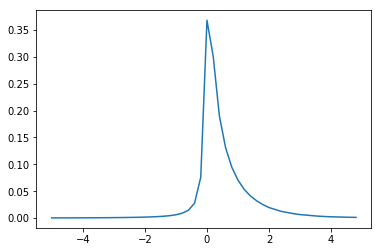

In [23]:
figE, axE = plt.subplots()
axE.plot(E_arr, spectrum_E_arr)